## Automated Stock Trading

In [48]:
## Warning Handling
import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in double_scalars")
warnings.filterwarnings("ignore", message="Mean of empty slice.")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

## Logging Setup
import sys
# sys.stdout = open("Investment_Logs.txt", "w")

In [49]:
## API Library Setup
import os

## Robinhood API Setup
import robin_stocks as rs
# Connecting to RobinHood
rs.login(
    username = os.getenv("RH_LOGIN"),
    password = os.getenv("RH_PASS"),
    expiresIn = 3600*24*7,
    by_sms = True
)

## Alpaca API Setup
import alpaca_trade_api as tradeapi
# Connecting to Alpaca
api = tradeapi.REST(os.getenv("AP_KEY"),os.getenv("AP_SECRET"), api_version='v2')
apip = tradeapi.REST(os.getenv("APP_KEY"),os.getenv("APP_SECRET"), api_version='v2',base_url='https://paper-api.alpaca.markets')

In [106]:
N_DAYS_AGO = 365
OLS_Window = 5
min_list_years = 5
min_volume = 400000
min_investment = 15


## Account ## (rh = Robin hood, ap = Alpaca Live, app = Alpaca Paper)
Account = "app"

In [162]:
## Installing Required Packages
import sys
from time import sleep
import math
import pickle
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date, time
from collections import defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from scipy import stats

## Setting Project Folder
Project_Folder = "C://Users//" + os.getlogin() + "//documents//github//Stock-Strategy-Exploration//"

## Reading In Functions
Function_Files = os.listdir('Functions')
for File in Function_Files:
    if '.py' in File:
        print(File)
        Full_File = 'Functions/'+File
        exec(open(Full_File).read())
        
def years_listed(d1):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.today()
    return abs((d2 - d1).days/365)

max_investment = Get_Equity(Account)*0.2
max_investment

API_Helpers.py
Group_Consolidator.py
Stock_Consolidator.py
Technical_Indicators.py


19864.152000000002

### Historical Data Pull

In [108]:
## Pulling All Available Alpaca Symbols
assets = api.list_assets("active")
Final_Assets = [i._raw['symbol'] for i in assets \
                if i._raw['tradable'] \
                    & i._raw['shortable'] \
                    & i._raw['easy_to_borrow']]

## Pulling All Bar Data
s_inc = 100
print("Starting Initial Data Pull")
Splits = [0]
while Splits[len(Splits)-1] < (len(Final_Assets)-1):
    if Splits[len(Splits)-1] + s_inc > (len(Final_Assets)-1):
        Splits.append((len(Final_Assets)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + s_inc)
Initial_Bars = {}
for i in tqdm(range(1,len(Splits))):
    Initial_Bars.update(api.get_barset(symbols = Final_Assets[Splits[i-1]:Splits[i]],
                                      timeframe = 'day',
                                      limit = N_DAYS_AGO))

print("Filtering Based On Average Price and Volume")
## Filtering Based On Price And Volume Criteria
Stocks = []
for i in tqdm(Final_Assets):
    try:
        Price_Data = Initial_Bars[i].df
        Price = np.mean(Price_Data['close'])
        Volume = np.mean(Price_Data['volume'])
        if Price < max_investment \
        and Price > min_investment \
        and i in Final_Assets \
        and Volume > min_volume:
            Stocks.append(i)
    except:
        print("Skipped",i,"No Data")

print("Pulling Company Data")
## Pulling Polygon Company Data
Splits = [0]
while Splits[len(Splits)-1] < (len(Stocks)-1):
    if Splits[len(Splits)-1] + 50 > (len(Stocks)-1):
        Splits.append((len(Stocks)-1))
    else:
        Splits.append(Splits[len(Splits)-1] + 50)
Company_Data = {}
for i in tqdm(range(1,len(Splits))):
    Company_Data.update(api.polygon.company(Stocks[Splits[i-1]:Splits[i]]))

## Filtering Based on Company Information
Updated_Stocks = list(Company_Data.keys())
Final_Stocks = []
for i in Updated_Stocks:
    if not Company_Data[i].active:
        continue
    if years_listed(Company_Data[i].listdate) > min_list_years:
        Final_Stocks.append(i)
        
## Amount of Historical Data to Pull
start_date = datetime.now() - timedelta(days=N_DAYS_AGO)
Historical_Data = defaultdict(pd.DataFrame)

print("Formatting Final Dataset")
## Formatting Final Dataset
counter = 0
for i in tqdm(Final_Stocks):
    TMP = Initial_Bars[i].df
    TMP['date'] = TMP.index
    TMP['sector'] = Company_Data[i].sector
    TMP['industry'] = Company_Data[i].industry
    Historical_Data[i] = TMP 

## Adding Ticker Column
for s in Historical_Data:
    Historical_Data[s].insert(0, 'stock', [s]*len(Historical_Data[s]))

## Combining Data To Single Data Frame
Combined_Data = pd.concat(Historical_Data.values())  
Combined_Data = Combined_Data[Combined_Data['sector'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['sector'])]
Combined_Data = Combined_Data[Combined_Data['industry'] != '']
Combined_Data = Combined_Data[pd.notnull(Combined_Data['industry'])]

## Saving Data
pickle.dump(Combined_Data, open(Project_Folder + "Data//Historical_Data.p" , "wb" ) )

Starting Initial Data Pull



Filtering Based On Average Price and Volume


Skipped BHP No Data

Pulling Company Data



Formatting Final Dataset


### Exploring Total Market Performance

In [109]:
## Loading Stored Data
Combined_Data = pickle.load(open(Project_Folder + "Data//Historical_Data.p" , "rb" ))
Combined_Data = Combined_Data.drop_duplicates()
Combined_Data = Combined_Data[(datetime.now() - timedelta(days = N_DAYS_AGO)).strftime("%Y-%m-%d"):datetime.now().strftime("%Y-%m-%d")]

Total_Market = Stock_Consolidator(Combined_Data)
Total_Market = Total_Market.loc[Total_Market.RSI > 0,:]
Total_Market.tail(10)

,close,high,low,open,volume,count,close_diff,close_return,volume_diff,sma,RSI,MACD
date,,,,,,,,,,,,
2020-10-13 00:00:00-04:00,92.347536,93.604038,91.217825,92.407535,3.184325e+06,1136.0,-0.002387,0.043603,0.100932,91.593340,52.023873,0.688018
2020-10-14 00:00:00-04:00,91.853536,93.597524,91.120143,92.583274,3.084306e+06,1136.0,-0.005349,0.018405,-0.031410,91.925340,66.613542,0.609690
2020-10-15 00:00:00-04:00,91.966639,92.559808,89.923553,90.571982,2.939556e+06,1137.0,0.001231,0.010320,-0.046931,92.113216,68.858231,0.531128
2020-10-16 00:00:00-04:00,91.813604,93.402781,91.137063,92.329092,3.073621e+06,1137.0,-0.001664,-0.000178,0.045607,92.109955,65.897914,0.438342
2020-10-19 00:00:00-04:00,90.765327,93.184738,90.262564,92.262919,2.739106e+06,1137.0,-0.011417,-0.019479,-0.108834,91.749329,66.997571,0.283373
2020-10-20 00:00:00-04:00,91.089702,92.621581,90.326125,91.316559,2.966592e+06,1137.0,0.003574,-0.013621,0.083051,91.497762,61.338564,0.184508
2020-10-21 00:00:00-04:00,90.494414,92.330035,89.749367,91.129681,2.802195e+06,1137.0,-0.006535,-0.014797,-0.055416,91.225937,60.991887,0.066877
2020-10-22 00:00:00-04:00,91.068195,92.070497,89.346395,90.579714,3.408576e+06,1137.0,0.006341,-0.009769,0.216395,91.046248,60.753413,0.018107
2020-10-23 00:00:00-04:00,91.663274,92.456301,90.269471,91.515865,2.920612e+06,1137.0,0.006534,-0.001637,-0.143158,91.016182,59.974533,0.016371


In [7]:
## Run to Update Total Market Data
Total_Market.to_csv(Project_Folder + "Data//Historical_Data.csv")

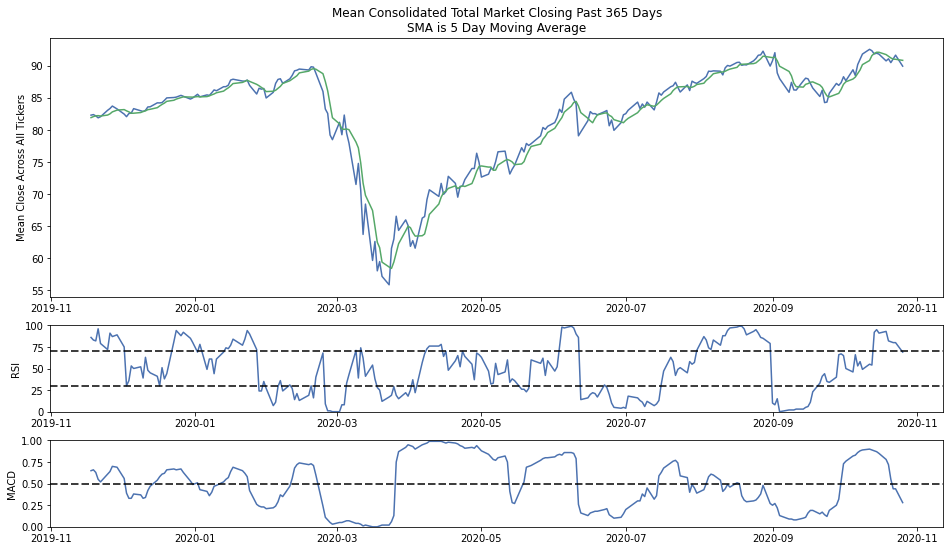

In [110]:
Plot_Data = Total_Market
Plot_Data['RSI'] = pd.qcut(Plot_Data.RSI,100,labels = False)
# Plot_Data['RSI'] = ((Plot_Data['RSI'] -  np.min(Plot_Data['RSI'])) / (np.max(Plot_Data['RSI']) - np.min(Plot_Data['RSI'])))*100
Plot_Data['MACD'] = pd.qcut(Plot_Data.MACD,100,labels = False)/100
# Plot_Data['MACD'] = (1 + 1)*((Plot_Data['MACD'] -  np.min(Plot_Data['MACD'])) / (np.max(Plot_Data['MACD']) - np.min(Plot_Data['MACD']))) - 1

Plot_Data['date'] = Plot_Data.index.get_level_values('date')
Plot_Data = Plot_Data.reset_index(drop = True)
x = Plot_Data['date']

fig, axs = plt.subplots(3,1,gridspec_kw={'height_ratios':[3,1,1]})
axs[0].plot(x,Plot_Data['close'])
axs[0].plot(x,Plot_Data['sma'])
axs[1].plot(x,Plot_Data['RSI'])
axs[1].axhline(y = 70,c = 'black',dashes = (5,2))
axs[1].axhline(y = 30,c = 'black',dashes = (5,2))
axs[2].plot(x,Plot_Data['MACD'])
axs[2].axhline(y = 0.50,c = 'black',dashes = (5,2))

axs[0].set(title = "Mean Consolidated Total Market Closing Past "+ str(N_DAYS_AGO) +" Days\nSMA is " + str(OLS_Window) +" Day Moving Average",
      ylabel = "Mean Close Across All Tickers",
      xlabel = "")
axs[1].set(ylabel = "RSI",
      xlabel = "",
      ylim = [0,100])
axs[2].set(
    ylabel = "MACD",
    xlabel = "",
    ylim = [0,1]
)
fig.set_size_inches(16,9)

## Digging Into A Sector Ranking

In [111]:
Sectors = list(Combined_Data['sector'].unique())
Total_Sector_Summary = Group_Consolidator(
    Combined_Data = Combined_Data,
    groups = Sectors,
    column = 'sector'
)
Sector_Summary = Group_Consolidator(Combined_Data = Combined_Data,
                                    groups = Sectors,
                                    column = 'sector',
                                    min_macd = 0,
                                    min_alpha = 0,
                                    max_alpha_p = 0.75,
                                    max_rsi = 70,
                                    q = 0.20
)
if len(Sector_Summary) == 0:
    Sector_Summary = list()
    print("No Viable Sectors Currently")

Sector_Summary.drop(['mu_day_up','sd_day_up','mu_day_down','sd_day_down'],axis = 1)

,last_period_return,last_price,quant_day_up,quant_day_down,sd_ret,sd_loss,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
sector,,,,,,,,,,,,,,
Energy,-0.003780,23.556162,0.008905,-0.007264,0.013069,0.012701,1.028974,-0.001188,46.424545,0.073223,0.003722,0.60,2.340196,0.0
Financial Services,0.000467,66.028021,0.012166,-0.003332,0.005916,0.007720,0.766321,0.000902,50.200547,0.022570,0.002185,0.28,1.141536,0.0


## Diving Further Into Individual Idustries

In [112]:
if type(Sector_Summary) is not list:
    Top_Sector = Combined_Data[Combined_Data['sector'].isin(Sector_Summary.index.values)]
    Industries = list(Top_Sector['industry'].unique())
    Industry_Summary = Group_Consolidator(Combined_Data = Top_Sector,
                                          groups = Industries,
                                          column = 'industry',
                                          min_macd = 0,
                                          min_alpha = 0,
                                          max_alpha_p = 0.50,
                                          max_rsi = 70,
                                          q = 0.20
                                         )
else:
    print("No sectors to loop through")
    Industry_Summary = list()
Industry_Summary.drop(['mu_day_up','sd_day_up','mu_day_down','sd_day_down'],axis = 1)

,last_period_return,last_price,quant_day_up,quant_day_down,sd_ret,sd_loss,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
industry,,,,,,,,,,,,,,
Oil & Gas - Drilling,0.041754,14.970000,0.002008,-0.000995,0.021244,0.021245,0.999953,0.002299,55.260538,0.138279,0.014640,0.00,3.314187,0.00
Banks,0.046426,44.222895,0.012909,-0.003720,0.009914,0.009419,1.052553,0.004317,58.477980,0.274531,0.012160,0.00,1.632010,0.00
Oil & Gas - Services,0.020710,12.420000,0.003953,-0.004581,0.014466,0.017365,0.833055,-0.000121,45.721746,0.111888,0.008181,0.29,2.128581,0.01
Insurance - Property & Casualty,0.029780,71.342200,0.009528,-0.004220,0.008417,0.008811,0.955283,0.001241,55.534419,0.212738,0.007374,0.45,0.745840,0.45
Insurance,0.021624,46.930000,0.009666,-0.003769,0.006123,0.009483,0.645682,0.000087,44.584754,0.118432,0.006952,0.23,1.420767,0.02
Insurance - Life,0.008324,32.465000,0.006180,-0.001770,0.011145,0.014134,0.788524,-0.000745,56.202975,0.000267,0.005404,0.27,1.987279,0.00


## Diving Into The Individual Stocks

In [113]:
if type(Industry_Summary) is not list:
    Top_Industry = Top_Sector[Top_Sector['industry'].isin(Industry_Summary.index.values)]
    Stocks = list(Top_Industry['stock'].unique())
    Stock_Summary = Group_Consolidator(Combined_Data = Top_Industry,
                                       groups = Stocks,
                                       column = 'stock',
                                       min_macd = 0,
                                       min_alpha = 0,
                                       max_alpha_p = 0.50,
                                       max_rsi = 50,
                                       q = 0.33
    )
    Stock_Summary. \
        sort_values(by = ['rsi'],ascending = [1])
else:
    print("No industries to loop through")
    Stock_Summary = list()
Stock_Summary.drop(['mu_day_up','sd_day_up','mu_day_down','sd_day_down'],axis = 1)

,last_period_return,last_price,quant_day_up,quant_day_down,sd_ret,sd_loss,risk_ratio,mu_ret,rsi,macd,alpha,alpha_p,beta,beta_p
stock,,,,,,,,,,,,,,
CBSH,0.076280,63.07,0.012323,-0.002413,0.011177,0.009644,1.158959,0.004809,47.225533,0.516869,0.017620,0.01,1.493518,0.02
FMBI,0.076014,12.74,0.016564,-0.005242,0.014956,0.012369,1.209152,0.006618,44.444444,0.145373,0.015571,0.02,0.419355,0.52
FFIN,0.070604,31.54,0.015888,-0.004826,0.012141,0.013946,0.870572,0.003812,49.560117,0.180571,0.013558,0.15,-0.173405,0.85
PB,0.036977,57.49,0.013376,0.000388,0.011999,0.011230,1.068477,0.003397,48.501873,0.353356,0.011242,0.04,2.088998,0.00
HSBC,0.044859,20.73,0.004842,-0.000968,0.024501,0.013879,1.765329,0.002626,48.755884,0.168546,0.010964,0.05,1.153315,0.04
BAC,0.033713,24.53,0.008284,-0.004988,0.009616,0.012609,0.762630,0.000001,37.909112,0.055641,0.009284,0.15,1.399432,0.03
ACGL,0.019739,30.48,0.010137,-0.005624,0.011760,0.011211,1.048970,-0.000110,44.152696,0.076271,0.007634,0.38,1.933000,0.03
CLB,0.014132,15.07,0.007605,-0.006210,0.013094,0.015800,0.828734,-0.001327,41.878716,0.133089,0.006975,0.44,2.157952,0.02
MFC,0.009979,14.17,0.008115,-0.000712,0.008975,0.012631,0.710553,-0.001109,40.402050,0.007789,0.005188,0.16,1.714929,0.00


In [122]:
## Pulling Current Stock Holdings
Current_Holdings = Get_Holdings(Account)

## Combining Lists
if isinstance(Current_Holdings,pd.DataFrame):
    if Current_Holdings.empty:
        Stocks = []
    else:
        Stocks = list(Current_Holdings.keys())
else:
    if not Current_Holdings:
        Stocks = []
    else:
        Stocks = [i.symbol for i in Current_Holdings]
        
if len(Stock_Summary) != 0:
    Stocks.extend(list(Stock_Summary.index))
Stocks = list(set(Stocks))

## Pulling Historical Data
Stock_Data = pd.DataFrame()
for Stock in Stocks:
    Stock_Data[Stock] = Combined_Data['close'][Combined_Data.stock == Stock].tail(OLS_Window*3)
    
## Creating expected mean and variance matricies
mu = expected_returns.mean_historical_return(Stock_Data)#returns.mean() * 252
S = risk_models.sample_cov(Stock_Data) #Get the sample covariance matrix

## Optimizing Sharpe Ratio
ef = EfficientFrontier(
    expected_returns = mu,
    cov_matrix = S, 
    weight_bounds = (0,0.2),
    verbose = False
)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 

## Subsetting Stock Picks
Final_Picks = []
for stock in cleaned_weights.keys():
    if cleaned_weights[stock] > 0:
        print(stock," : ",cleaned_weights[stock])
        Final_Picks.append(stock)
        
Optimized_Portfolio = ef.portfolio_performance(verbose=True)

HSBC  :  0.12297
SAVE  :  0.05586
FFIN  :  0.02117
XYL  :  0.2
DOV  :  0.2
FMBI  :  0.2
CBSH  :  0.2
Expected annual return: 199.0%
Annual volatility: 23.2%
Sharpe Ratio: 8.48


## Robinhood Automated Investing POC

In [178]:
## Quantile for Deciding Limit Orders
q = 0.20
## Quantile for Deciding Stop Loss / Take Profit Orders
qsp = 0.90

## Pulling Relevent Account Information
Account_Equity = Get_Equity(Account)

## Pulling Open Orders
Open_Orders = Get_Open_Orders(Account)

## Pulling Current Stock Holdings
Current_Holdings = Get_Holdings(Account)

## Checking Portfolio Balancing And Placing New Orders
for s in Final_Picks:

    # Optimal Portfolio Percentage
    Rcm_Holding = cleaned_weights[s]*100
    
    # Portfolio Restructuring
    if s in list(Current_Holdings.keys()):
        
        # Current Portfolio Percentage
        Pct_Holding = np.round(float(Current_Holdings[s].equity)*100/Account_Equity,2)
        Pct_Return = float(Current_Holdings[s]['percent_change'])

        # Rebalancing If Beyond Recommended Holding
        if Pct_Holding > Rcm_Holding*1.05 and Pct_Return > 0:
            Rebalance_Lower(s,q,Account)
            
        # Checking If More Needs Purchased
        elif Pct_Holding < Rcm_Holding*0.95 and Pct_Return > 0:
            Rebalance_Higher(s,q,Account)
            
        # Make No Changes    
        else:
            print("\n",s," Within Recommended Percentage")
            Exit_Orders(s,q = qsp,Account = Account)        
     
    ## Stocks Not Currently Held
    else:
        Open_Position(s,q,Account)
        
## Closing Required Positions
if Current_Holdings.empty:
     print("\nNo positions to close, none are held")
else:
    for s in [s for s in list(Current_Holdings.keys()) if s not in Final_Picks]:
        Close_Position(s,Account)



Opening HSBC Position

 SAVE  Within Recommended Percentage

Setting Stop Loss For SAVE At: 16.35

Order Failed For SAVE
{'detail': 'Not enough shares to sell.'}


Opening FFIN Position

 XYL  Within Recommended Percentage

Setting Stop Loss For XYL At: 88.13

Order Failed For XYL
{'detail': 'Never bought shares in that Instrument.'}

 DOV  Within Recommended Percentage

Setting Stop Loss For DOV At: 111.87

Order Failed For DOV
{'detail': 'Not enough shares to sell.'}


Opening FMBI Position


Opening CBSH Position


Closing CM Position

Canceling Existing Order: 2b4b6574-3fcd-4db3-8bb2-099ca9639aef

Order Failed For CM
Order({   'asset_class': 'us_equity',
    'asset_id': '9bac708f-f6f3-411a-a320-5d31f36b6a7d',
    'canceled_at': None,
    'client_order_id': '3eecc694-3abf-45ab-bc08-3a3744eeee22',
    'created_at': '2020-10-27T00:53:08.629191Z',
    'expired_at': None,
    'extended_hours': False,
    'failed_at': None,
    'filled_at': None,
    'filled_avg_price': None,
    'fill

In [177]:
s = 'HSBC'
Rcm_Holding = cleaned_weights[s]*100

12.296999999999999